In [1]:
'''
DCGAN on MNIST using Keras
Author: Rowel Atienza
Project: https://github.com/roatienza/Deep-Learning-Experiments
Dependencies: tensorflow 1.0 and keras 2.0
Usage: python3 dcgan_mnist.py
'''

import numpy as np
import time
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import LeakyReLU, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

path="DCGAN/"
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model
    def save(self, file_path):
        self.AM.save(file_path)

    def load(self, file_path):
        self.AM = tf.keras.models.load_model(file_path)
        self.DM = self.AM.layers[1]
        self.D = self.DM.layers[0]
        self.G = self.AM.layers[0]

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 3, strides=2, input_shape=input_shape, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 3, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 3, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 3, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self, noise_dim=100):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.2
        depth = 64+64+64+64 #64*4=256
        dim = int(self.img_rows/4) #7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=noise_dim))
        self.G.add(BatchNormalization(momentum=0.8))
        self.G.add(Activation(LeakyReLU(alpha=0.2)))
        self.G.add(Reshape((dim, dim, depth)))# 7*7*256
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 3, padding='same'))
        self.G.add(BatchNormalization(momentum=0.8))
        self.G.add(Activation(LeakyReLU(alpha=0.2)))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 3, padding='same'))
        self.G.add(BatchNormalization(momentum=0.8))
        self.G.add(Activation(LeakyReLU(alpha=0.2)))

        self.G.add(Conv2DTranspose(int(depth/8), 3, padding='same'))
        self.G.add(BatchNormalization(momentum=0.8))
        self.G.add(Activation(LeakyReLU(alpha=0.2)))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(self.channel, 3, padding='same'))
        self.G.add(Activation('tanh'))#sigmoid ?
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = Adam(1e-4)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = Adam(1e-4)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

class MNIST_DCGAN(object):
    def __init__(self,img_rows = 28, img_cols = 28, channel=1, model_name=None):
        self.img_rows = img_rows #32 #28
        self.img_cols = img_cols #32 #28
        self.channel = channel # 1
        (self.x_train, self.y_train), (self.x_test, self.y_test) = tf.keras.datasets.cifar10.load_data()

        self.x_train = self.x_train.reshape(-1, self.img_rows,\
        	self.img_cols,  self.channel).astype(np.float32)*2/255 - 1

        self.DCGAN = DCGAN(self.img_rows , self.img_cols,self.channel)
        if model_name is None:
            self.discriminator =  self.DCGAN.discriminator_model()
            self.adversarial = self.DCGAN.adversarial_model()
            self.adversarial.summary()
            self.generator = self.DCGAN.generator()
        else:
            self.SSLGAN.load(model_name)
            self.discriminator = self.SSLGAN.DM
            self.generator = self.SSLGAN.G
            self.adversarial = self.SSLGAN.AM

        self.generator_optimizer = tf.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.optimizers.Adam(1e-4)
        self.BACC_D1 = tf.keras.metrics.BinaryAccuracy()
        self.BACC_D2 = tf.keras.metrics.BinaryAccuracy()
        self.BACC_G1 = tf.keras.metrics.BinaryAccuracy()

    def discriminator_loss(self, real_output, fake_output):
        bce = tf.keras.losses.BinaryCrossentropy()
        loss = bce(tf.ones_like(real_output), real_output)
        real_loss = tf.reduce_mean(loss)
        loss = bce(tf.zeros_like(fake_output), fake_output)
        fake_loss = tf.reduce_mean(loss)

        total_loss = real_loss + fake_loss
        #BACC = tf.keras.metrics.BinaryAccuracy()
        self.BACC_D1.update_state(tf.ones_like(real_output), real_output)
        accuracy1 =self.BACC_D1.result()
        self.BACC_D2.update_state(tf.zeros_like(fake_output), fake_output)
        accuracy2 =self.BACC_D2.result()
        return total_loss, (accuracy1+accuracy2)/2.0

    # Define the loss function for the generator
    def generator_loss(self, fake_output):
        real_output = tf.ones_like(fake_output)
        bce = tf.keras.losses.BinaryCrossentropy()
        loss = bce(real_output , fake_output)
        gen_loss = tf.reduce_mean(loss)
        #self.BACC = tf.keras.metrics.BinaryAccuracy()
        self.BACC_G1.update_state(real_output, fake_output)
        accuracy = self.BACC_G1.result()
        return gen_loss, accuracy
    # Define a function to compute and apply gradients for the discriminator
    @tf.function
    def train_discriminator(self, images, batch_size=256, noise_dim=100):
        with tf.GradientTape() as disc_tape:
            generated_images = self.generator(tf.random.normal([batch_size, noise_dim]), training=True)
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            disc_loss, disc_acc = self.discriminator_loss(real_output, fake_output)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return disc_loss, disc_acc

    # Define a function to compute and apply gradients for the generator
    @tf.function
    def train_generator(self,batch_size=256, noise_dim=100):
        with tf.GradientTape() as gen_tape:
            generated_images = self.generator(tf.random.normal([batch_size, noise_dim]), training=True)
            fake_output = self.discriminator(generated_images, training=True)
            gen_loss, gen_acc = self.generator_loss(fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        return gen_loss, gen_acc

    def train(self, train_steps=2000, batch_size=256, save_interval=100, noise_dim=100, K=3):
        d_loss_history=[]
        a_loss_history=[]
        noise_input = None
        if save_interval>0:
            noise_input = tf.random.normal([64, noise_dim]) #np.random.uniform(-1.0, 1.0, size=[64, 100])#Or tf.random.normal([16, 100])?
        for i in range(train_steps):
            tmp=[]
            for k in range(K):
                images_train = self.x_train[np.random.randint(0,self.x_train.shape[0], size=batch_size), :, :, :]#get real images
                d_loss=self.train_discriminator(images_train,batch_size, noise_dim ) #train the Discriminator network
                tmp.append(d_loss)
            d_loss_history= d_loss_history + tmp

            a_loss= self.train_generator(batch_size, noise_dim)
            a_loss_history.append(a_loss)

            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            if i%100==0:
                #print("K:", K)
                print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0], noise=noise_input, step=(i+1))
        return d_loss_history, a_loss_history

    def plot_images(self, save2file=False, fake=True, samples=64, noise=None, step=0, noise_dim=100):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise =tf.random.normal([samples, noise_dim]) # np.random.uniform(-1.0, 1.0, size=[samples, 100])#Or tf.random.normal([batch_size, 100])?
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(20,20))
        for i in range(images.shape[0]):
            plt.subplot(8, 8, i+1)
            image = (images[i, :, :, :]+1)*255/2
            image = np.reshape(image, [self.img_rows, self.img_cols, self.channel])
            plt.imshow(image.astype(np.uint8), cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(path+filename)
            plt.close('all')
        plt.show()




170498071/170498071 [==============================] - 13s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                    

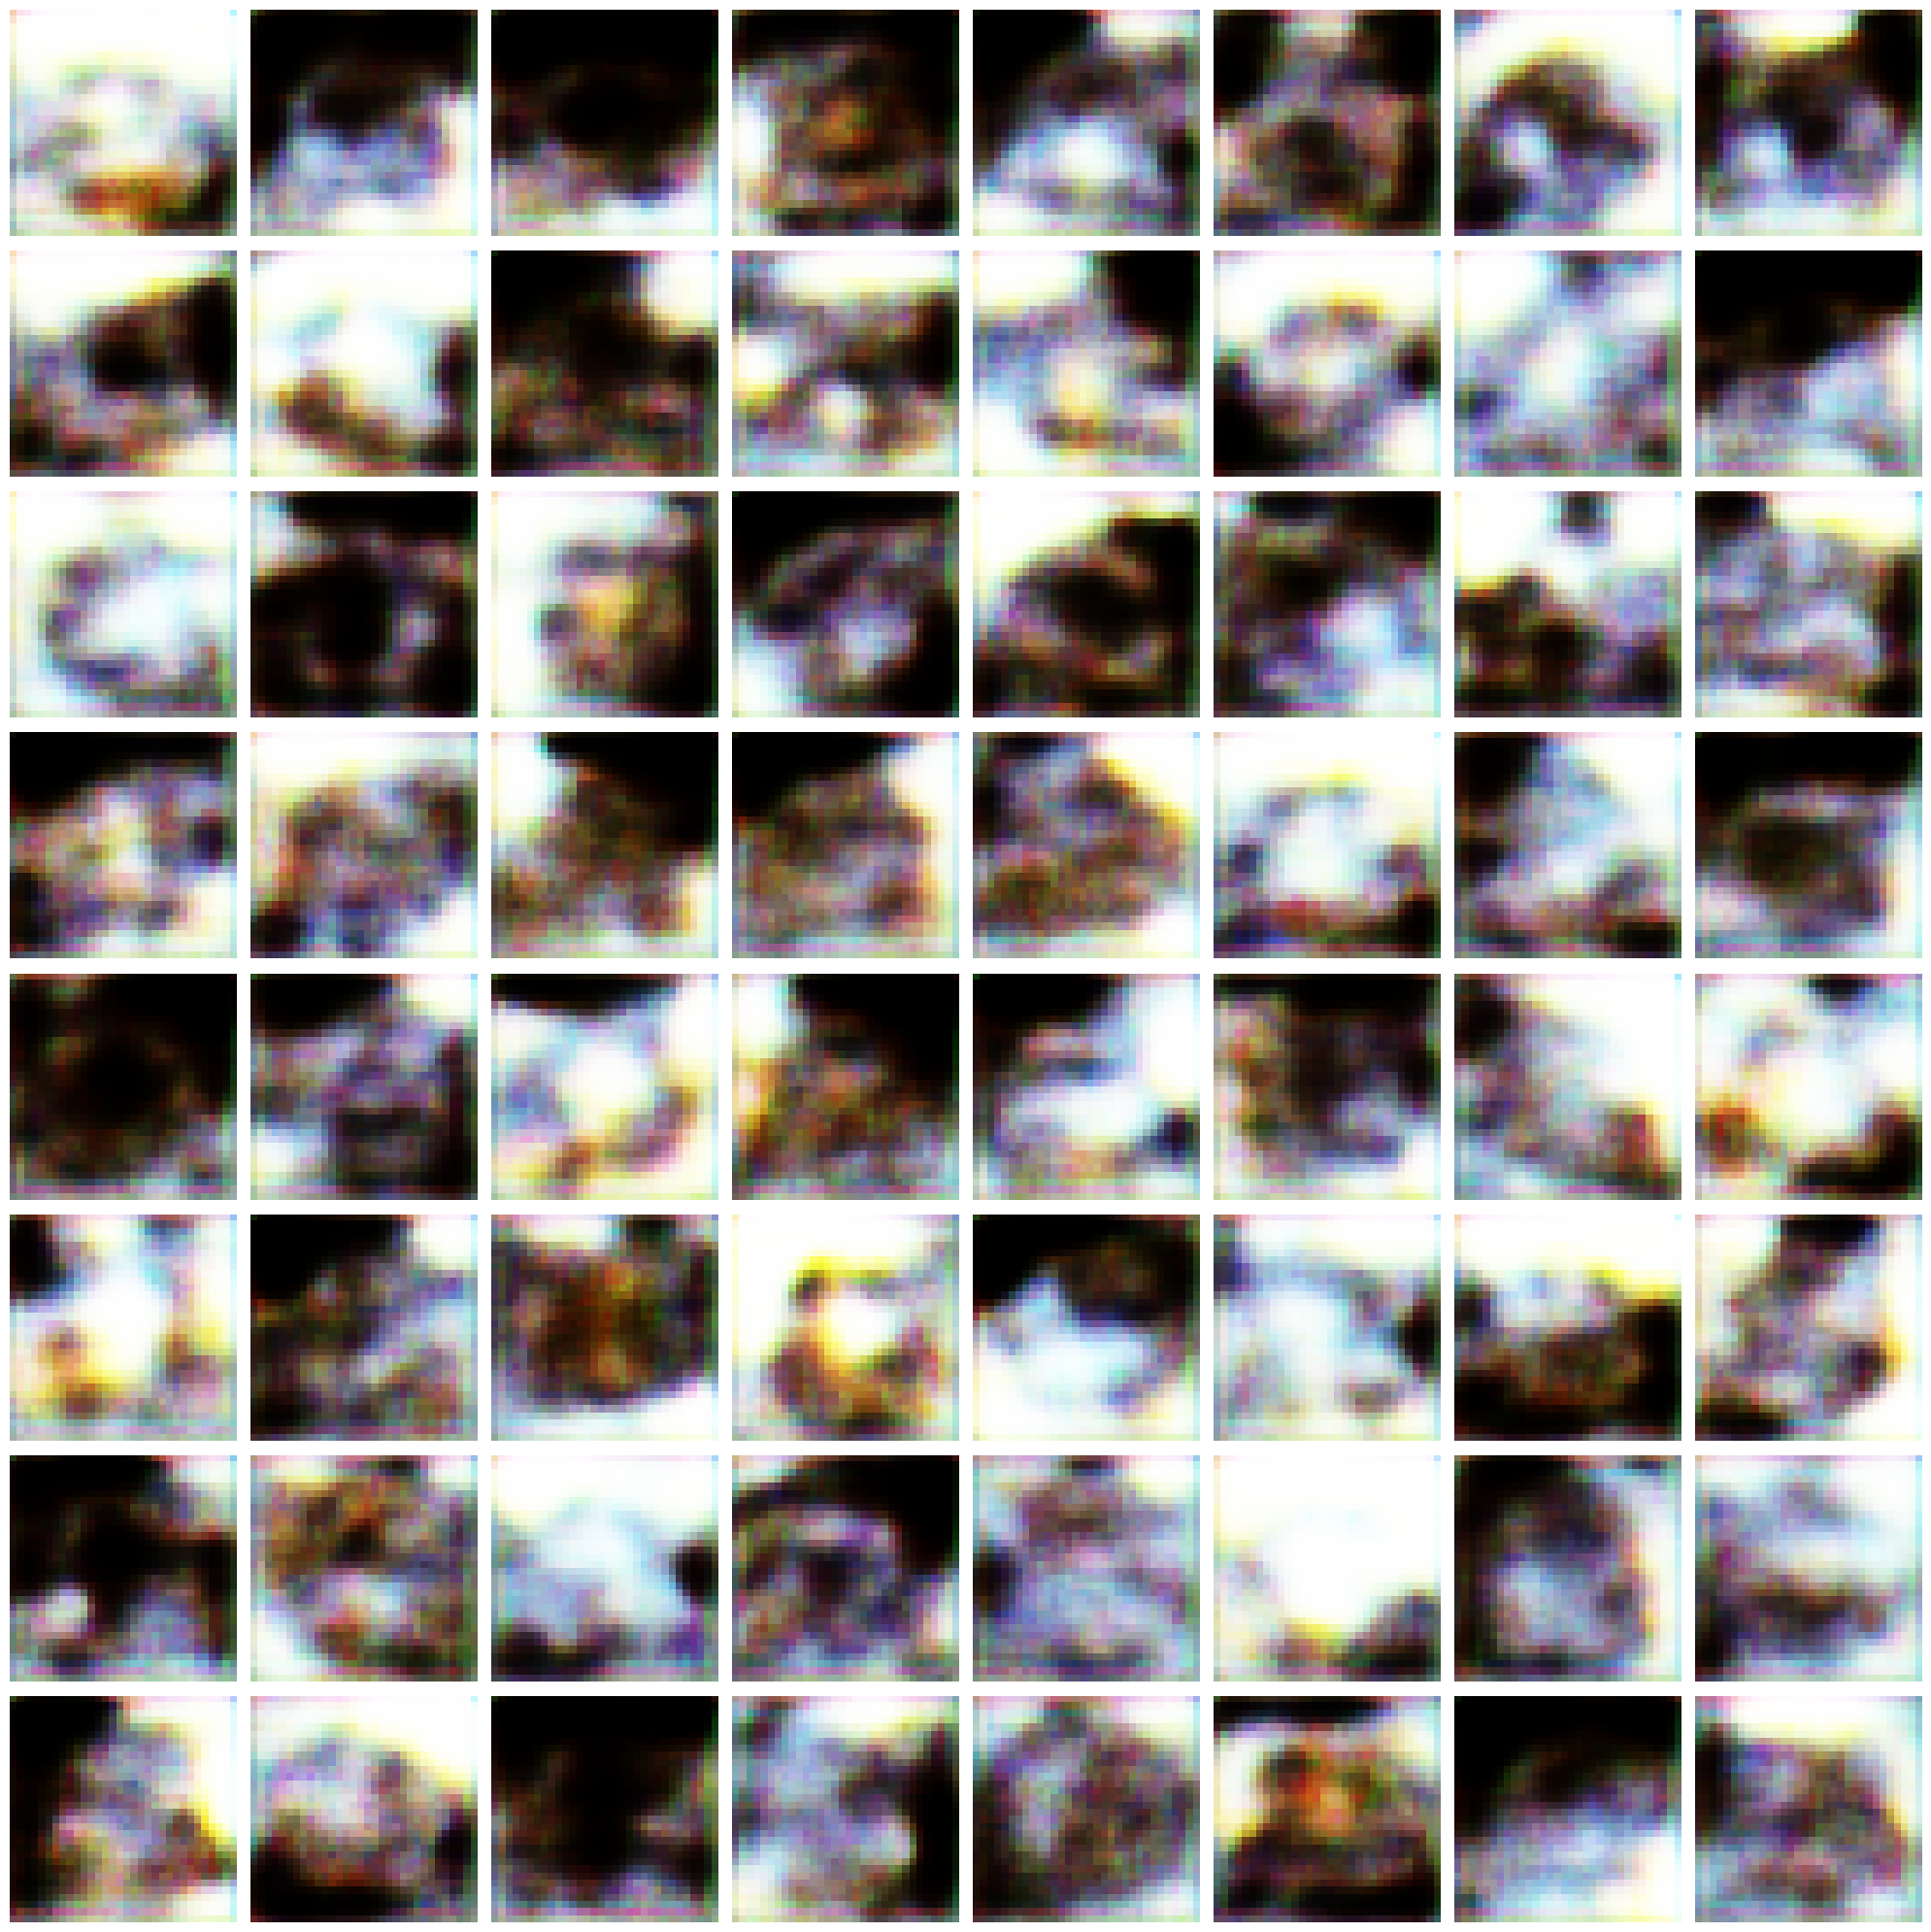

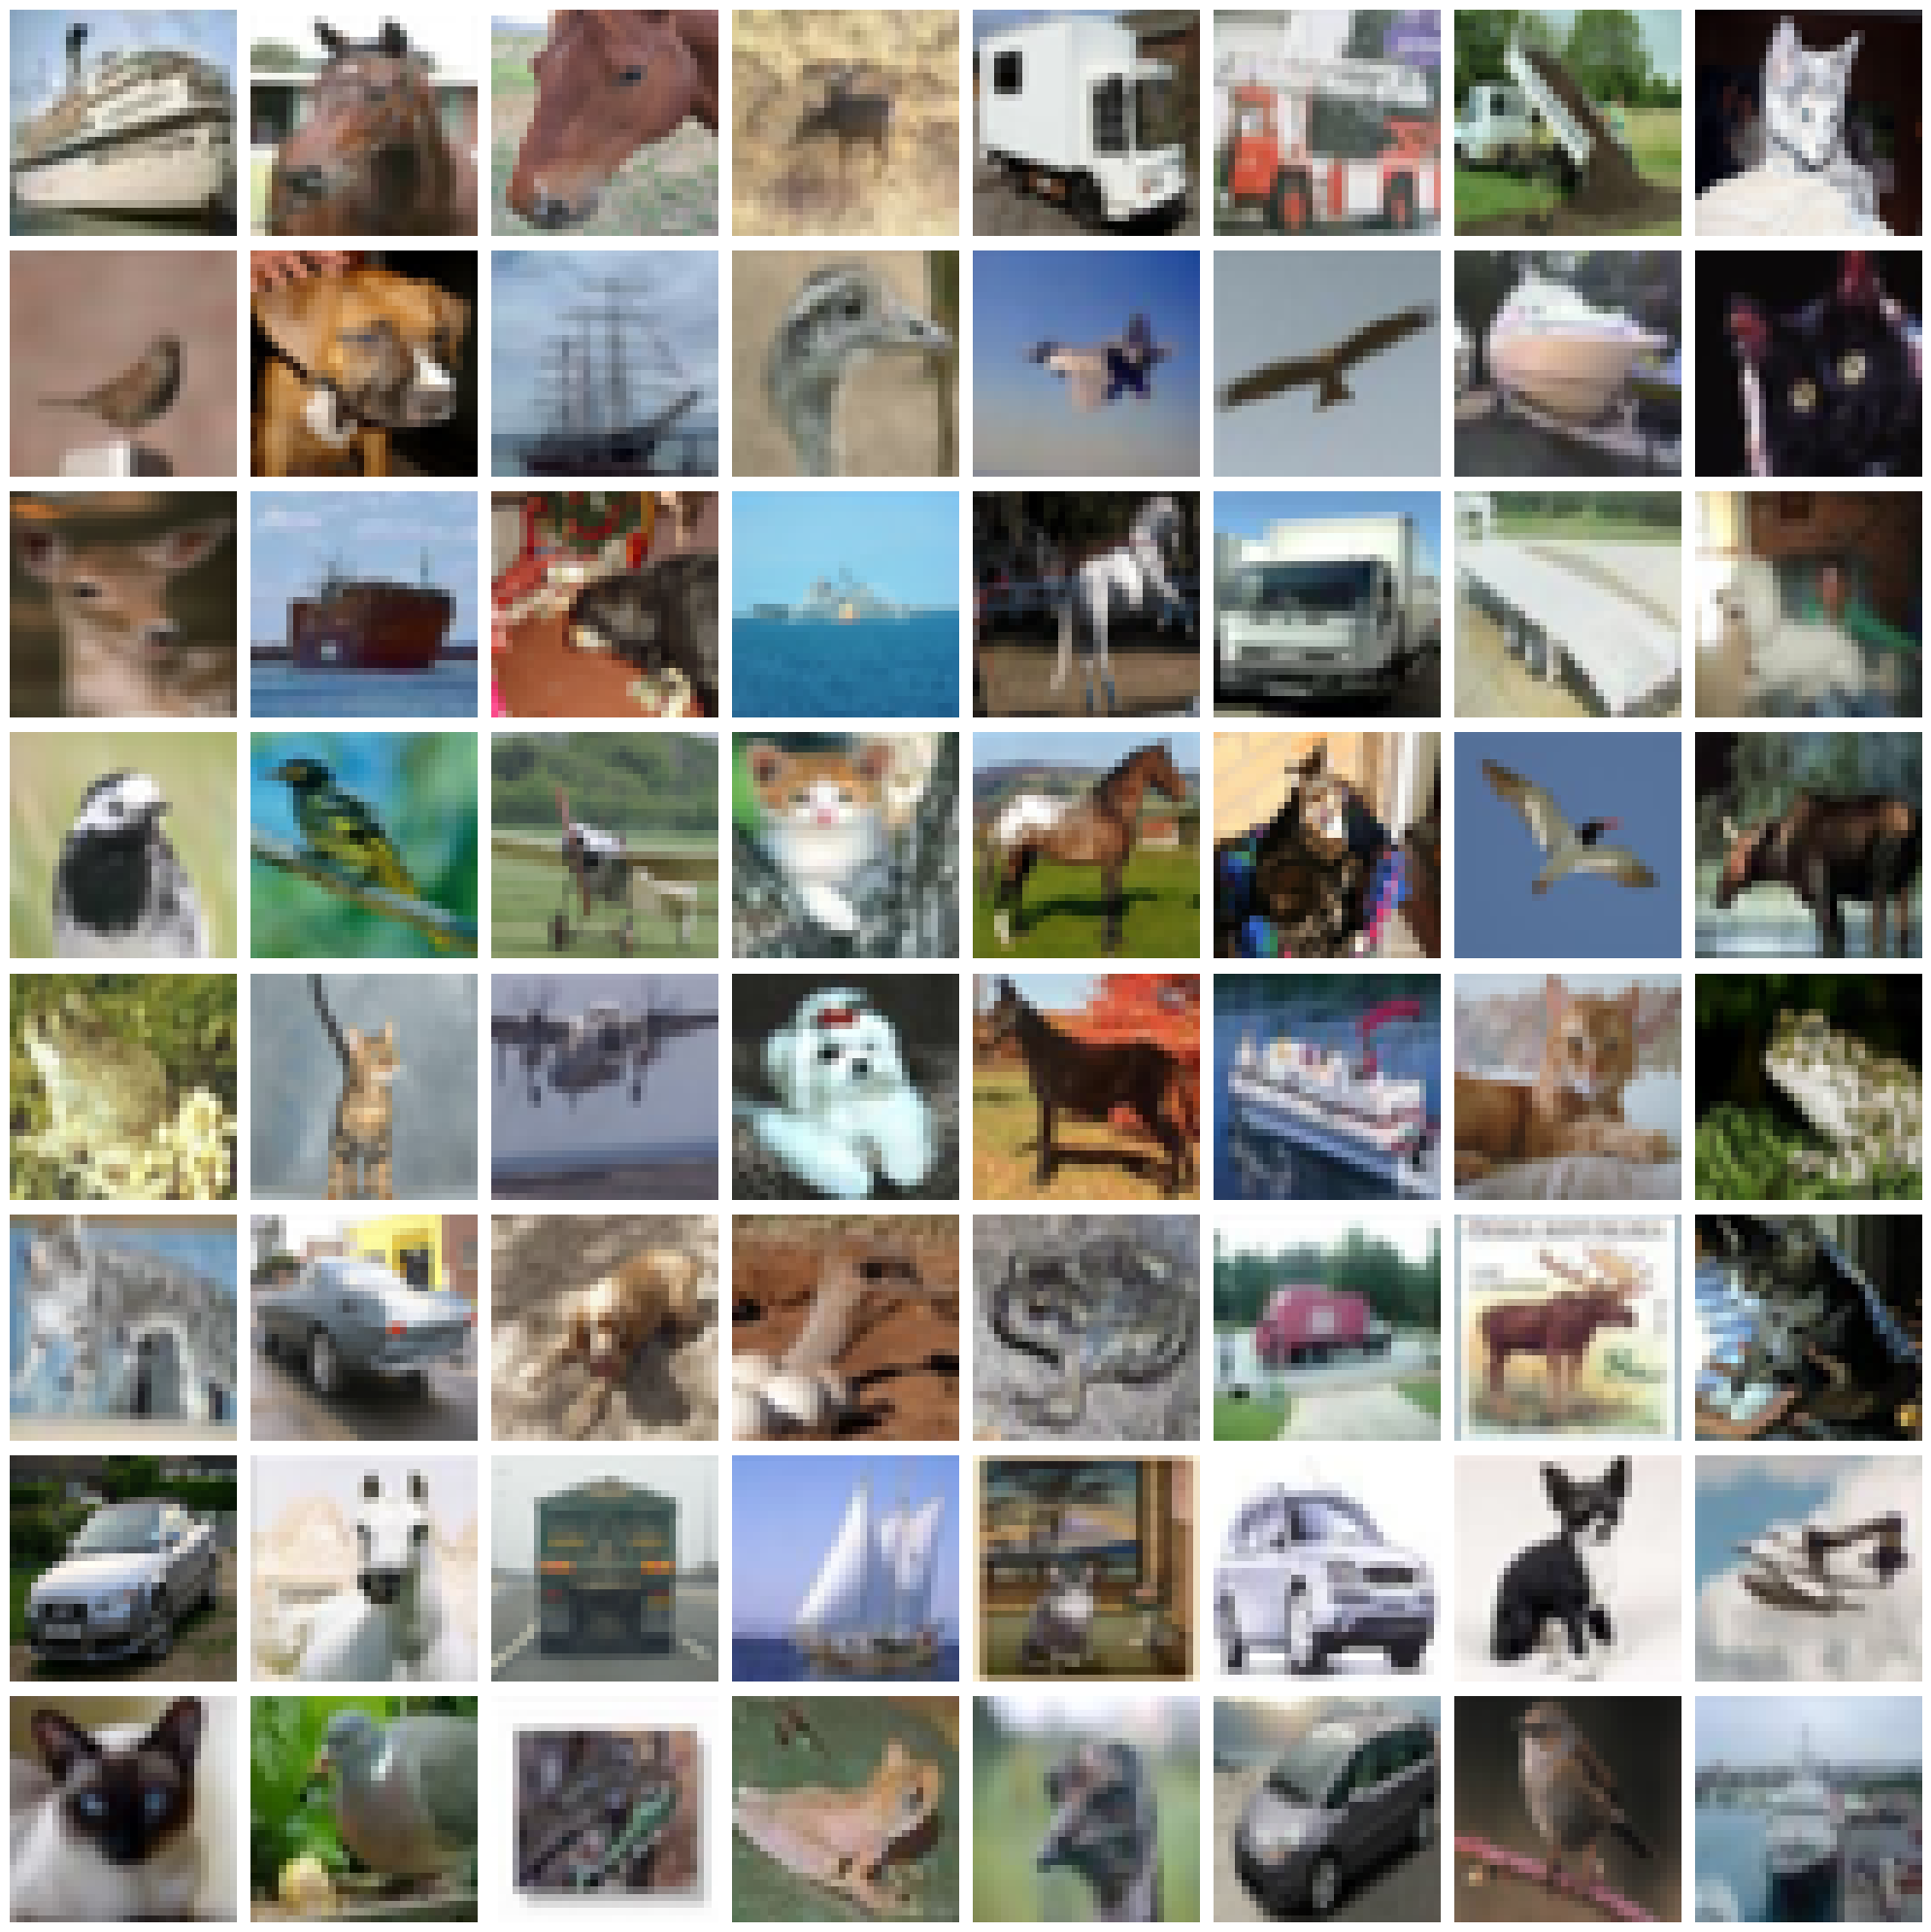

In [2]:
if __name__ == '__main__':
    mnist_dcgan = MNIST_DCGAN(img_rows = 32, img_cols = 32, channel=3) #Test CIFAR10
    timer = ElapsedTimer()
    d_history, a_history = mnist_dcgan.train(train_steps=100, batch_size=1024, save_interval=10)
    timer.elapsed_time()
    mnist_dcgan.plot_images(fake=True)
    mnist_dcgan.plot_images(fake=False, save2file=False)


In [ ]:
mnist_dcgan.DCGAN.save("E:/DCGAN/dcgan_model.h5")

In [ ]:
mnist_dcgan.DCGAN.load("E:/DCGAN/dcgan_model.h5")

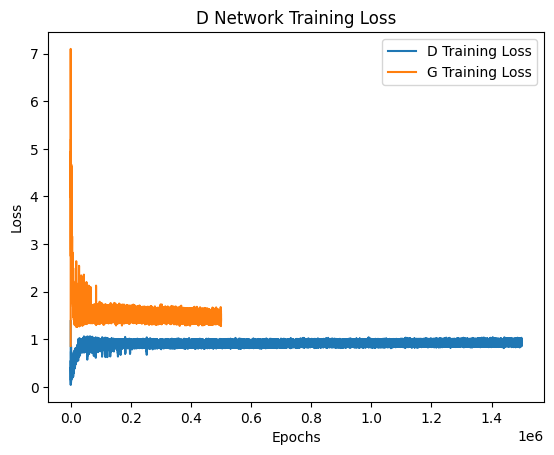

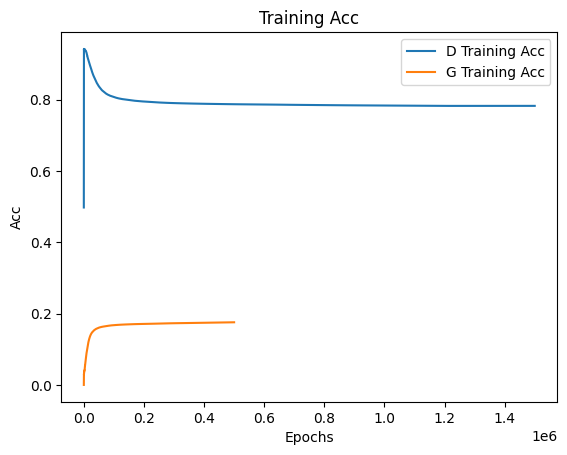

In [ ]:
import matplotlib.pyplot as plt

history = d_history
d_loss= [ elem[0] for elem in history]
d_acc = [ elem[1] for elem in history]

history = a_history
g_loss= [ elem[0] for elem in history]
g_acc = [ elem[1] for elem in history]
# 繪製訓練損失和驗證損失的走勢圖
plt.plot(d_loss, label='D Training Loss')
plt.plot(g_loss, label='G Training Loss')
plt.title('D Network Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(d_acc, label='D Training Acc')
plt.plot(g_acc, label='G Training Acc')
plt.title('Training Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:

import pickle
# Define the file path
file_path = "E:/DCGAN/d_history1"
# Save the list of objects to a file
with open(file_path, 'wb') as file:
    pickle.dump( d_history, file)

# Define the file path
file_path = "E:/DCGAN/g_history1"
# Save the list of objects to a file
with open(file_path, 'wb') as file:
    pickle.dump( a_history, file)

In [ ]:
timer = ElapsedTimer()
d_history, a_history = mnist_dcgan.train(train_steps=500000, batch_size=1024, save_interval=1000)
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=False)


In [ ]:
!pip install opencv-python

In [ ]:
import cv2
import numpy as np


def generate_images(model, fake=False, samples=32, noise=None, noise_dim=100):

    if noise is None:
        noise =tf.random.normal([samples, noise_dim]) # np.random.uniform(-1.0, 1.0, size=[samples, 100])#Or tf.random.normal([batch_size, 100])?

    if fake:
        images = model.generator.predict(noise)
        path="E:/SSLGAN_CIFAR10/FakeImgData/"
    else:
        path="E:/SSLGAN_CIFAR10/RealImgData/"
        i = np.random.randint(0, model.x_train.shape[0], samples)
        images = model.x_train[i, :, :, :]

    for i in range(images.shape[0]):
        filename = path+ "cifar10_%d.png" % i
        img = ((images[i, :, :, :]+1)*255/2).astype(np.uint8)
        cv2.imwrite(filename, img)

generate_images(cifar10_sslgan,fake=True)
generate_images(cifar10_sslgan,fake=False)

In [ ]:
import numpy as np
import tensorflow as tf
import os
import pathlib
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from scipy.linalg import sqrtm


# 計算Inception Score（IS）
def calculate_inception_score(images, model, batch_size=32, splits=10):
    preds = []
    n_batches = int(np.ceil(float(len(images)) / float(batch_size)))

    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch = images[start_idx:end_idx]
        batch = preprocess_input(batch)
        preds.append(model.predict(batch))

    preds = np.concatenate(preds, axis=0)
    scores = []
    for i in range(splits):
        part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

# 計算Fréchet Inception Distance（FID）
def calculate_fid(real_images, generated_images, model, batch_size=32):
    act1 = model.predict(real_images, batch_size=batch_size)
    act2 = model.predict(generated_images, batch_size=batch_size)
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# 載入Inception模型
def load_inception_model():
    base_model = InceptionV3(include_top=True, pooling='avg', input_shape=(299, 299, 3))
    model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)
    return model

# 載入圖像
def load_images(image_paths, image_size=(299, 299)):
    images = []
    for path in image_paths:
        img = Image.open(path)
        img = np.asarray(img.resize(image_size))
        if len(img.shape)==3:
          img = img[:,:,0:3] #discard the alpha dimension
        else:
          color_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
          # Set RGB channels to grayscale values
          color_image[:,:,0] = img
          color_image[:,:,1] = img
          color_image[:,:,2] = img
          img = color_image
        images.append(img)
    return np.array(images)

# 設定圖像路徑
real_image_paths = [ 'E:/SSLGAN_CIFAR10/RealImgData/cifar10_%d.png' % i for i in range(32)]
generated_image_paths =[ 'E:/SSLGAN_CIFAR10/FakeImgData/cifar10_%d.png' % i for i in range(32)]

# 載入Inception模型
inception_model = load_inception_model()

# 載入圖像
real_images = load_images(real_image_paths)
generated_images = load_images(generated_image_paths)

# 計算並輸出Inception Score
is_mean, is_std = calculate_inception_score(generated_images, inception_model)
print("Inception Score: Mean = {}, Std = {}".format(is_mean, is_std))

# 計算並輸出Fréchet Inception Distance
fid = calculate_fid(real_images, generated_images, inception_model)
print("Fréchet Inception Distance:", fid)
